In [1]:
!git clone https://github.com/Abdulrasheed1729/xai.git

Cloning into 'xai'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 52 (delta 16), reused 39 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 7.78 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import random, ast
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms
import os

from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [5]:
print(torch.__version__, torchvision.__version__)

2.9.0+cpu 0.24.0+cpu


See info and class indices at
https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/


In [6]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


# Classification function for LIME

Define the classification function LIME needs.
Input: numpy array of images where each image is ndarray of shape (channel, height, width).
Output: numpy array of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [7]:
def prediction_function(images):
    model.eval()
    images_transformed = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    logits = model(images_transformed)
    preds = logits.softmax(dim=1)
    return preds.detach().cpu().numpy()

# Image loading and preprocessing

In [9]:
with open("xai/LIME/imagenet1000_clsidx_to_labels.txt", "r", encoding="utf-8") as f:
    text = f.read()
labels_dict = ast.literal_eval(text)

In [10]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

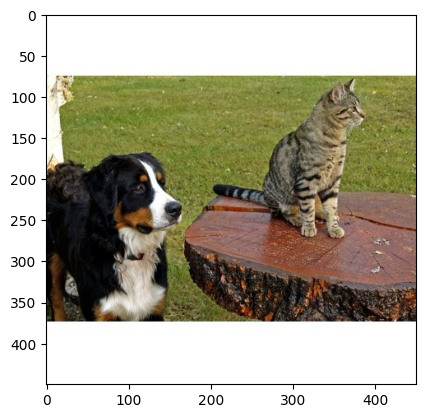

In [11]:
img = get_image('xai/data/cat_dog.png')
plt.imshow(img)
plt.show()

# LIME

In [12]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         prediction_function,
                                         # number of labels (with highest prob) to show
                                         top_labels=5,
                                         # size of the neighborhood to learn the linear model
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
explanation.top_labels

[np.int64(240), np.int64(239), np.int64(241), np.int64(238), np.int64(281)]

In [14]:
top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

['Appenzeller', 'Bernese mountain dog', 'EntleBucher', 'Greater Swiss Mountain dog', 'tabby, tabby cat']


Overlay the mask on from LIME on the image to see which areas encourage the top prediction

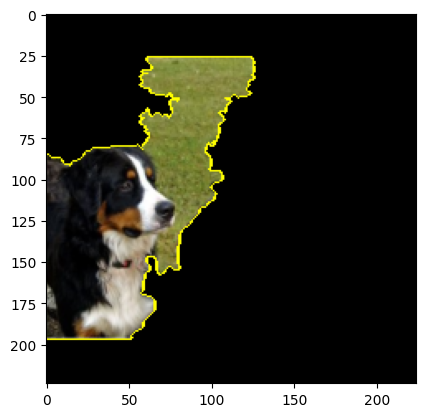

In [15]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[1],
                                              # only include superpixels contributing positively
                                             positive_only=True,
                                             # number of superpixels to show
                                             num_features=6,
                                             # turn off the non-explanation part
                                             hide_rest=True)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()

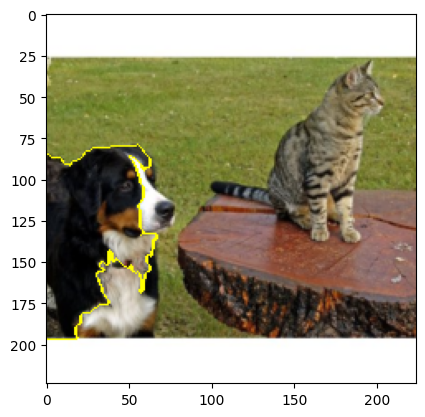

In [16]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[1],
                                              # only include superpixels contributing positively
                                             positive_only=True,
                                             # number of superpixels to show
                                             num_features=3,
                                             # turn off the non-explanation part
                                             hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()

Display areas also areas that contribute against the top prediction.

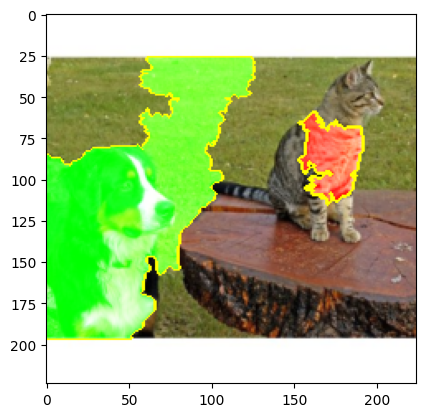

In [18]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[1],
                                                         positive_only=False,
                                                         negative_only=False,
                                                         num_features=7,
                                                         hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()

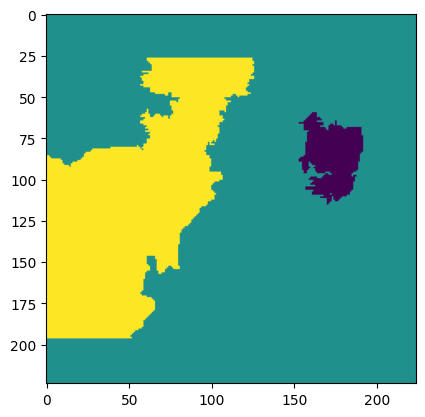

In [19]:
plt.imshow(mask)
plt.show()

In [20]:
np.unique(np.array(mask))

array([-1,  0,  1])

## Other images

  0%|          | 0/1000 [00:00<?, ?it/s]

['tench, Tinca tinca', 'bolete', 'armadillo', 'isopod', 'mud turtle']


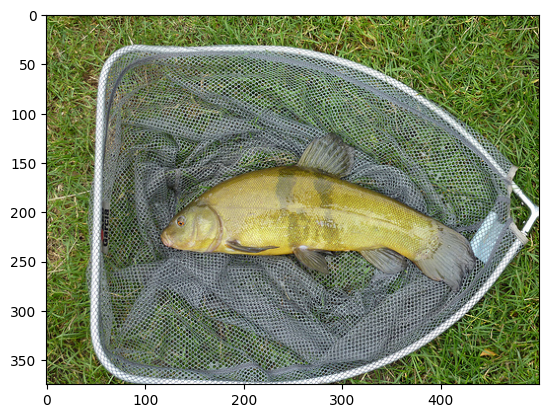

In [21]:
img = get_image('xai/data/fish.jpg')
plt.imshow(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         prediction_function,
                                         top_labels=5,
                                         num_samples=1000)

top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

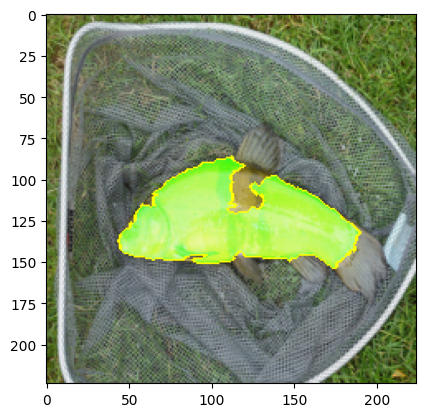

In [22]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                             positive_only=False,
                                             num_features=3,
                                             hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

['coral reef', 'scuba diver', 'rock beauty, Holocanthus tricolor', 'jellyfish', 'anemone fish']


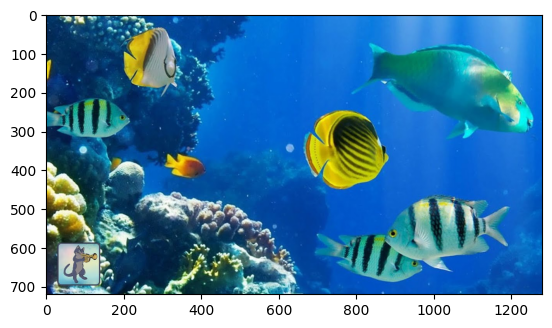

In [24]:
img = get_image('xai/data/aquarium.jpg')
plt.imshow(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         prediction_function,
                                         top_labels=5,
                                         num_samples=1000)

top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

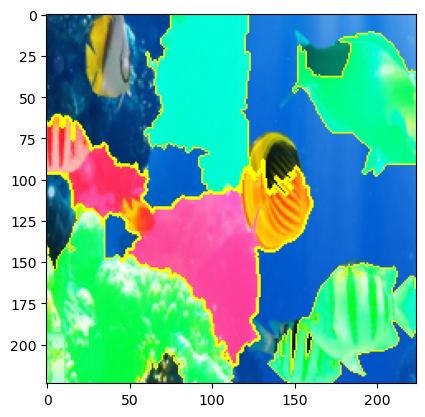

In [ ]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                             positive_only=False,
                                             num_features=10,
                                             hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()

## Your own picture

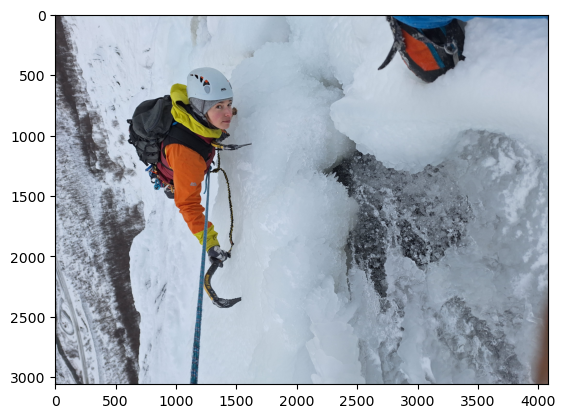

In [ ]:
img = get_image('../data/inga_ice.jpg')
plt.imshow(img)
plt.show()

In [ ]:
top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

['ski', 'shovel', 'snowmobile', 'snowplow, snowplough', 'ski mask']


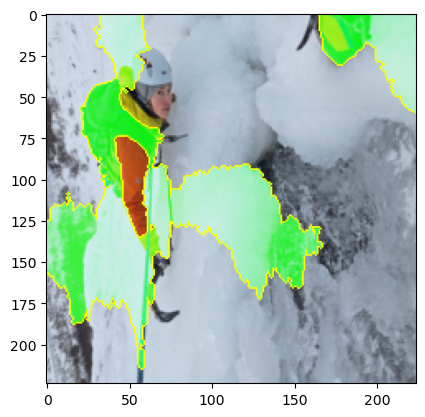

In [ ]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                             positive_only=False,
                                             num_features=5,
                                             hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)
plt.show()